In [2]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

# Predictores

Partiendo de la función estimada:

$$y[k] = G_e(z)u[k] + H_e(z)e[k]$$

Conociendo los valores de la entrada $u[k]$ y la salida $y[k]$, desconociendo la señal de error $e[k]$ y habiendo estimado $G_e$ y $H_e$, se puede usar dichas funciones de transferencia despejar el error desconocido, así:

$$e[k] = -H_e(z)^{-1}G_e(z)u[k] + H_e(z)^{-1}y[k]$$

Planteando que el error debe ser entre el modelo que se estima $y_e[k]$ y las mediciones $y[k]$, se puede decir que:

$$e[k] = y[k] - y_e[k]$$

Por lo tanto:

$$e[k] = y[k] - y_e[k] = -H_e(z)^{-1}G_e(z)u[k] + H_e(z)^{-1}y[k]$$

Despejando la estimación se obtendría:

$$y_e[k] = y[k] + H_e(z)^{-1}G_e(z)u[k] - H_e(z)^{-1}y[k]$$

$$y_e[k] = (1 - H_e(z)^{-1})y[k] + H_e(z)^{-1}G_e(z)u[k]$$

Reemplazano H y G por los valores de A(z) y B(z), se obtiene:

$$y_e[k] = (1 - A(z))y[k] + B(z)u[k]$$

## Ejemplo 2

Obtenda la señal estimada usando los polinomios calculados en el ejemplo anterior:

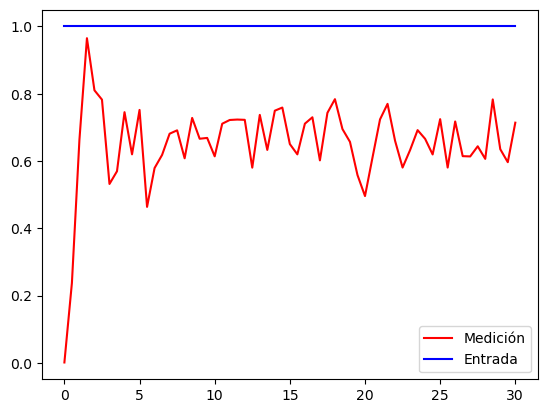

In [8]:
## Sistema de segundo orden en tiempo continuo
g = control.tf([6],[2,3,9])

## Periodo de muestreo y num de muestras para la discretización de la respuesta al escalón
t0 = 0
tf = 30
dt = 0.5
N = int((tf-t0)/dt)+1
t = np.linspace(t0,tf,N)

# Señal de salida ideal "y"
u = np.ones(N)
_,y = control.step_response(g,t)

## Ruido para simular la señal de salida capturada "yn"
r = 0.08
e = np.random.normal(0,r,size=N)

yn = y+e
plt.plot(t,yn,color = 'red')
plt.plot(t,u,color = 'blue')
plt.legend(['Medición','Entrada'])

In [41]:
## Definir y_1, y_2, y_3, dependiendo el sistema que se quiera modelar
y_1 = np.zeros(N)
y_2 = np.zeros(N)
u_1 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    
## Creación del vector phi
phi = np.array([-y_1,-y_2,u_1]).transpose()

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 0.0
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.14771062, -0.13538077,  0.48112161])

In [54]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2  
B = theta[2]*z**-1 

## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()

H = 1/A
H = H.simplify()

## Definiendo las funciones del predictor:
## 1 - H^-1 = 1- A y H^-1*G = B

print('A continuación se observa el valor de 1-A y de B, para reconstruir')
_A = (1-A).simplify()
print(_A)
print(B)

A continuación se observa el valor de 1-A y de B, para reconstruir
(0.14771062132052*z + 0.135380766173951)/z**2
0.481121605714343/z


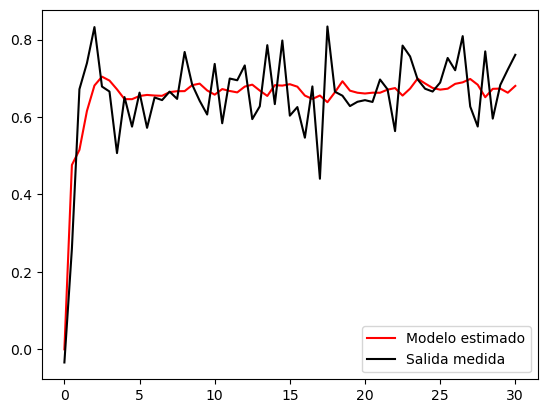

In [55]:
## Definiendo la función a estimar:

ye = -theta[0]*y_1-theta[1]*y_2+theta[2]*u_1
plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.legend(['Modelo estimado','Salida medida'])

In [56]:
ECM = np.sqrt(np.dot((yn-ye).transpose(),(yn-ye)))/len(yn)
print(ECM)

0.010958796696275051
